In [ ]:
!pip install ultralytics roboflow supervision==0.19.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.3/872.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import numpy.typing as npt
import supervision as sv
import os
import cv2
from ultralytics import YOLO
from PIL import Image

from dataclasses import replace
from typing import Iterable, Optional, Tuple

from supervision import Detections
from supervision.detection.utils import clip_boxes, polygon_to_mask
from supervision.draw.color import Color
from supervision.draw.utils import draw_polygon, draw_text
from supervision.geometry.core import Position
from supervision.geometry.utils import get_polygon_center
from supervision.utils.internal import deprecated_parameter

In [ ]:
%cd /content/drive/MyDrive
HOME = os.getcwd()
MODEL = f"{HOME}/runs/detect/train4/weights/best.pt"

# initialize the model
model = YOLO(MODEL)
model.fuse()

/content/drive/MyDrive
Model summary (fused): 268 layers, 43,608,921 parameters, 0 gradients, 164.8 GFLOPs


In [ ]:
def detect(frame: np.ndarray) -> sv.Detections:
    result = model.predict(frame, imgsz=1280, conf=0.5, verbose=False)[0]
    return sv.Detections.from_ultralytics(result)

In [ ]:
def point_in_rect(px: int, py: int, rx1: int, ry1: int, rx2: int, ry2: int) -> bool:
    """
    Check if a point (px, py) is inside a rectangle defined by its top-left (rx1, ry1)
    and bottom-right (rx2, ry2) coordinates.

    Parameters:
    px (float): x-coordinate of the point.
    py (float): y-coordinate of the point.
    rx1 (float): x-coordinate of the rectangle's top-left corner.
    ry1 (float): y-coordinate of the rectangle's top-left corner.
    rx2 (float): x-coordinate of the rectangle's bottom-right corner.
    ry2 (float): y-coordinate of the rectangle's bottom-right corner.

    Returns:
    bool: True if the point is inside the rectangle, False otherwise.
    """
    return rx1 <= px <= rx2 and ry1 <= py <= ry2

def rectangles_intersect(r1_p1: tuple[int, int], r1_p2: tuple[int, int],
                         r2_p1: tuple[int, int], r2_p2: tuple[int, int]) -> bool:
    """
    Check if two rectangles intersect. Each rectangle is defined by two points:
    the top-left and the bottom-right corners.

    Parameters:
    r1_p1 (tuple[float, float]): Top-left corner of the first rectangle (x1, y1).
    r1_p2 (tuple[float, float]): Bottom-right corner of the first rectangle (x2, y2).
    r2_p1 (tuple[float, float]): Top-left corner of the second rectangle (x1, y1).
    r2_p2 (tuple[float, float]): Bottom-right corner of the second rectangle (x2, y2).

    Returns:
    bool: True if the rectangles intersect, False otherwise.
    """
    # Unpack rectangle points
    r1_x1, r1_y1 = r1_p1
    r1_x2, r1_y2 = r1_p2
    r2_x1, r2_y1 = r2_p1
    r2_x2, r2_y2 = r2_p2

    r1_width = abs(r1_x1 - r1_x2)
    r2_width = abs(r2_x1 - r2_x2)
    if r1_width == 0 or r2_width == 0:
        return False

    # Define the vertices for both rectangles
    r1_vertices = [(r1_x1, r1_y1), (r1_x2, r1_y1), (r1_x2, r1_y2), (r1_x1, r1_y2)]
    r2_vertices = [(r2_x1, r2_y1), (r2_x2, r2_y1), (r2_x2, r2_y2), (r2_x1, r2_y2)]

    # Check if any vertex of rectangle 1 is inside rectangle 2 or vice versa
    return any(point_in_rect(px, py, r2_x1, r2_y1, r2_x2, r2_y2) for px, py in r1_vertices) or \
           any(point_in_rect(px, py, r1_x1, r1_y1, r1_x2, r1_y2) for px, py in r2_vertices)



In [ ]:
# SOURCE_VIDEO_PATH = f"{HOME}/videos/yarik.mp4"
# frames_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
# frame = 0
# for i in range(300):
#     frame = next(frames_generator) # get the 1st frame

# # detections_untracked = detect(frame)
# # for i in range(len(detections_untracked)):
# #     obj = detections_untracked[i]
# #     print(obj.class_id[0])

# # detections = tracker.update_with_detections(detections_untracked)
# # print(detections)
# # for i in range(len(detections)):
# #     obj = detections[i]
# #     print(obj.class_id[0])

# detections = detect(frame)
# for obj in detections:
#     print(obj)



# video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)

# # zones_above = setup_zone_above(detections, video_info.resolution_wh)
# # zones_below = setup_zone_below(detections, video_info.resolution_wh)
# # zones_general = setup_zone_general(detections, video_info.resolution_wh, zones_above, zones_below)

# # labels for bounding boxes
# labels = [
#     f"{model.model.names[class_id]} {confidence:0.2f}"
#     for confidence, class_id
#     in zip(detections.confidence, detections.class_id)
# ]

# # draw bounding boxes
# annotated_frame = frame.copy()
# annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
# annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)

# # # draw zones
# # for zone in zones_above:
# #     annotated_frame = zone['PolygonZoneAnnotator'].annotate(
# #         scene=annotated_frame,
# #         label=f"{zone['name']}"
# #     )

# # for zone in zones_below:
# #     annotated_frame = zone['PolygonZoneAnnotator'].annotate(
# #         scene=annotated_frame,
# #         label=f"{zone['name']}"
# #     )

# # for zone in zones_general:
# #     annotated_frame = zone['PolygonZoneAnnotator'].annotate(
# #         scene=annotated_frame,
# #         label=f"{zone['name']}"
# #     )

# sv.plot_image(annotated_frame)

In [ ]:
class PolygonZone:
    """
    A class for defining a polygon-shaped zone within a frame for detecting objects.

    Attributes:
        polygon (np.ndarray): A polygon represented by a numpy array of shape
            `(N, 2)`, containing the `x`, `y` coordinates of the points.
        frame_resolution_wh (Tuple[int, int]): The frame resolution (width, height)
        triggering_anchors (Iterable[sv.Position]): A list of positions specifying
            which anchors of the detections bounding box to consider when deciding on
            whether the detection fits within the PolygonZone
            (default: (sv.Position.BOTTOM_CENTER,)).
        current_count (int): The curren|t count of detected objects within the zone
        mask (np.ndarray): The 2D bool mask for the polygon zone
    """

    @deprecated_parameter(
        old_parameter="triggering_position",
        new_parameter="triggering_anchors",
        map_function=lambda x: [x],
        warning_message="`{old_parameter}` in `{function_name}` is deprecated and will "
        "be remove in `supervision-0.23.0`. Use '{new_parameter}' "
        "instead.",
    )
    def __init__(
        self,
        polygon: npt.NDArray[np.int64],
        frame_resolution_wh: Tuple[int, int],
        triggering_anchors: Iterable[Position] = (Position.BOTTOM_CENTER,),

    ):
        self.polygon = polygon.astype(int)
        self.frame_resolution_wh = frame_resolution_wh
        self.triggering_anchors = triggering_anchors

        self.current_count = 0

        width, height = frame_resolution_wh
        self.mask = polygon_to_mask(
            polygon=polygon, resolution_wh=(width + 1, height + 1)
        )

    def trigger(self, detections: Detections, class_id):
        """
        Determines if the spicific objects are within the polygon zone.

        Return:
        False, if none of the ojects of the specified class are within the polygon zone.
        True, if at least one of the ojects of the specified class are within the polygon zone.
        """

        triggers = []

        for obj in iter(detections):
            if obj[3] == class_id: # check for ball
                obj_x1, obj_y1, obj_x2, obj_y2 = obj[0]
                obj_p1 = (obj_x1, obj_y1)
                obj_p2 = (obj_x2, obj_y2)

                zone_p1 = self.polygon[0]
                zone_p2 = self.polygon[2]

                triggers.append(rectangles_intersect(obj_p1, obj_p2, zone_p1, zone_p2))


            # if obj[5].get('class_name') == class_name:
            #     obj_x1, obj_y1, obj_x2, obj_y2 = obj[0]
            #     obj_p1 = (obj_x1, obj_y1)
            #     obj_p2 = (obj_x2, obj_y2)

            #     zone_p1 = self.polygon[0]
            #     zone_p2 = self.polygon[2]

            #     triggers.append(rectangles_intersect(obj_p1, obj_p2, zone_p1, zone_p2))

        return any(triggers)


class PolygonZoneAnnotator:
    """
    A class for annotating a polygon-shaped zone within a
        frame with a count of detected objects.

    Attributes:
        zone (PolygonZone): The polygon zone to be annotated
        color (Color): The color to draw the polygon lines
        thickness (int): The thickness of the polygon lines, default is 2
        text_color (Color): The color of the text on the polygon, default is black
        text_scale (float): The scale of the text on the polygon, default is 0.5
        text_thickness (int): The thickness of the text on the polygon, default is 1
        text_padding (int): The padding around the text on the polygon, default is 10
        font (int): The font type for the text on the polygon,
            default is cv2.FONT_HERSHEY_SIMPLEX
        center (Tuple[int, int]): The center of the polygon for text placement
        display_in_zone_count (bool): Show the label of the zone or not. Default is True
    """

    def __init__(
        self,
        zone: PolygonZone,
        color: Color,
        thickness: int = 2,
        text_color: Color = Color.BLACK,
        text_scale: float = 0.5,
        text_thickness: int = 1,
        text_padding: int = 10,
        display_in_zone_count: bool = True,
    ):
        self.zone = zone
        self.color = color
        self.thickness = thickness
        self.text_color = text_color
        self.text_scale = text_scale
        self.text_thickness = text_thickness
        self.text_padding = text_padding
        self.font = cv2.FONT_HERSHEY_SIMPLEX
        self.center = get_polygon_center(polygon=zone.polygon)
        self.display_in_zone_count = display_in_zone_count

    def annotate(self, scene: np.ndarray, label: Optional[str] = None) -> np.ndarray:
        """
        Annotates the polygon zone within a frame with a count of detected objects.

        Parameters:
            scene (np.ndarray): The image on which the polygon zone will be annotated
            label (Optional[str]): An optional label for the count of detected objects
                within the polygon zone (default: None)

        Returns:
            np.ndarray: The image with the polygon zone and count of detected objects
        """
        annotated_frame = draw_polygon(
            scene=scene,
            polygon=self.zone.polygon,
            color=self.color,
            thickness=self.thickness,
        )

        if self.display_in_zone_count:
            annotated_frame = draw_text(
                scene=annotated_frame,
                text=str(self.zone.current_count) if label is None else label,
                text_anchor=self.center,
                background_color=self.color,
                text_color=self.text_color,
                text_scale=self.text_scale,
                text_thickness=self.text_thickness,
                text_padding=self.text_padding,
                text_font=self.font,
            )

        return annotated_frame

In [ ]:
tracker = sv.ByteTrack()

# define annotation classes

bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=2)
label_annotator = sv.LabelAnnotator(text_thickness=1, text_scale=0.4)
trace_annotator = sv.TraceAnnotator(thickness=4)

In [ ]:
def setup_zone_above(detections, frame_wh):
    zones = []
    count_zone = 0
    for i in range(len(detections)):
        obj = detections[i]

        # choosing only baskets with confidence score >= 0.5
        if (obj.class_id[0] == 1) & (obj.confidence[0] >= 0.5):
            count_zone += 1

            obj_xyxy = obj.xyxy[0]

            # get coordinates of 4 points of bounding box
            obj_p1 = np.array([obj_xyxy[0], obj_xyxy[1]])
            obj_p2 = np.array([obj_xyxy[0], obj_xyxy[3]])
            obj_p3 = np.array([obj_xyxy[2], obj_xyxy[3]])
            obj_p4 = np.array([obj_xyxy[2], obj_xyxy[1]])

            # get height and width of bounding box
            obj_height = obj_xyxy[3] - obj_xyxy[1]
            obj_width = obj_xyxy[2] - obj_xyxy[0]

            # polygon construction strategy
            # 1) zone width: the width of the “basket” bounding box increased on 10% (5% from both
            # left and right sides).
            # 2) zone height: 60% of the height of the "basket" bounding box.
            # 3) zone location: higher on 10% of the "basket" bounding box height from the upper bound
            # of "basket" bounding box.

            zone_p1 = [obj_p1[0] - 0.05 * obj_width, obj_p1[1] - 0.7 * obj_height]
            zone_p2 = [obj_p1[0] - 0.05 * obj_width, obj_p1[1] - 0.1 * obj_height]
            zone_p3 = [obj_p4[0] + 0.05 * obj_width, obj_p4[1] - 0.1 * obj_height]
            zone_p4 = [obj_p4[0] + 0.05 * obj_width, obj_p4[1] - 0.7 * obj_height]

            # round coordinates of each point of zone
            zone_p1 = list(map(round, zone_p1))
            zone_p2 = list(map(round, zone_p2))
            zone_p3 = list(map(round, zone_p3))
            zone_p4 = list(map(round, zone_p4))

            zone_coordinates = np.array([zone_p1, zone_p2, zone_p3, zone_p4])
            zone_name = f"Zone {count_zone}"

            zone = {
                'name': zone_name,
                'polygon': zone_coordinates,
                'count': 0
            }

            zone['PolygonZone'] = PolygonZone(
                polygon=zone['polygon'],
                frame_resolution_wh=frame_wh
            )

            zone['PolygonZoneAnnotator'] = PolygonZoneAnnotator(
                zone=zone['PolygonZone'],
                color=sv.Color.WHITE,
                thickness=2,
                text_thickness=1,
                text_scale=0.3,
                text_padding=3
            )

            zones.append(zone)

    return zones


def setup_zone_below(detections, frame_wh):
    zones = []
    count_zone = 0
    for i in range(len(detections)):
        obj = detections[i]


        # choosing only baskets with confidence score >= 0.5
        if (obj.class_id[0] == 1) & (obj.confidence[0] >= 0.5):
            count_zone += 1

            obj_xyxy = obj.xyxy[0]

            # get coordinates of 4 points of bounding box
            obj_p1 = np.array([obj_xyxy[0], obj_xyxy[1]])
            obj_p2 = np.array([obj_xyxy[0], obj_xyxy[3]])
            obj_p3 = np.array([obj_xyxy[2], obj_xyxy[3]])
            obj_p4 = np.array([obj_xyxy[2], obj_xyxy[1]])

            # get height and width of bounding box
            obj_height = obj_xyxy[3] - obj_xyxy[1]
            obj_width = obj_xyxy[2] - obj_xyxy[0]

            # polygon construction strategy
            # 1) zone width: the width of the “basket” bounding box decreased on 95% (47.5% from both
            # left and right sides).
            # 2) zone height: 80% of the height of the "basket" bounding box.
            # 3) zone location: lower on 70% of the "basket" bounding box height from the lower bound
            # of "basket" bounding box.

            zone_p1 = [obj_p1[0] + 0.475 * obj_width, obj_p1[1] + 0.7 * obj_height]
            zone_p2 = [obj_p1[0] + 0.475 * obj_width, obj_p1[1] + 1.5 * obj_height]
            zone_p3 = [obj_p4[0] - 0.475 * obj_width, obj_p4[1] + 1.5 * obj_height]
            zone_p4 = [obj_p4[0] - 0.475 * obj_width, obj_p4[1] + 0.7 * obj_height]

            # round coordinates of each point of zone
            zone_p1 = list(map(round, zone_p1))
            zone_p2 = list(map(round, zone_p2))
            zone_p3 = list(map(round, zone_p3))
            zone_p4 = list(map(round, zone_p4))

            zone_coordinates = np.array([zone_p1, zone_p2, zone_p3, zone_p4])
            zone_name = f"Zone {count_zone}"

            zone = {
                'name': zone_name,
                'polygon': zone_coordinates,
                'count': 0
            }

            zone['PolygonZone'] = PolygonZone(
                polygon=zone['polygon'],
                frame_resolution_wh=frame_wh
            )

            zone['PolygonZoneAnnotator'] = PolygonZoneAnnotator(
                zone=zone['PolygonZone'],
                color=sv.Color.WHITE,
                thickness=2,
                text_thickness=1,
                text_scale=0.3,
                text_padding=3
            )

            zones.append(zone)

    return zones


def setup_zone_general(detections, frame_wh, zones_above, zones_below):
    general_zones = []

    for count_zone in range(len(zones_above)):

        # polygon construction strategy
        # 1) zone width: the width of the zone_above increased on 100% (50% from both
        # left and right sides)
        # 2) zone height: 260% of the height of the zone_above.
        # 3) zone location: lower on 10% of the height of zone_above from the lower bound of zone_above

        height_zone_above = zones_above[count_zone]['polygon'][1][1] - zones_above[count_zone]['polygon'][0][1]
        y1 = round(zones_above[count_zone]['polygon'][0][1] - 2.5 * height_zone_above) # the upper y coordinate
        y2 = round(zones_above[count_zone]['polygon'][1][1] + 0.1 * height_zone_above) # the lower y coordinate
        width = zones_above[count_zone]['polygon'][3][0] - zones_above[count_zone]['polygon'][0][0]
        x1 = round(zones_above[count_zone]['polygon'][0][0] - 0.5 * width)
        x2 = round(zones_above[count_zone]['polygon'][3][0] + 0.5 * width)

        general_zone_p1 = [x1, y1]
        general_zone_p2 = [x1, y2]
        general_zone_p3 = [x2, y2]
        general_zone_p4 = [x2, y1]

        general_zone_coord = np.array([general_zone_p1, general_zone_p2, general_zone_p3, general_zone_p4])

        general_zone_name = f"Zone {count_zone + 1}"

        general_zone = {
            'name': general_zone_name,
            'polygon': general_zone_coord,
            'count': 0
        }

        general_zone['PolygonZone'] = PolygonZone(
            polygon=general_zone['polygon'],
            frame_resolution_wh=frame_wh
        )

        general_zone['PolygonZoneAnnotator'] = PolygonZoneAnnotator(
            zone=general_zone['PolygonZone'],
            color=sv.Color.WHITE,
            thickness=2,
            text_thickness=1,
            text_scale=0.3,
            text_padding=3
        )

        general_zones.append(general_zone)

    return general_zones

def choosing_largest_zone(zones):
    max_square = 0
    for zone in zones:
        zone_coord = zone.get('polygon')
        x1 = zone_coord[0][0]
        x2 = zone_coord[3][0]
        y1 = zone_coord[0][1]
        y2 = zone_coord[0][1]

        square = (x2 - x1) * (y2 - y1)

        if square > max_square:
            max_square = square

    for zone in zones:
        zone_coord = zone.get('polygon')
        x1 = zone_coord[0][0]
        x2 = zone_coord[3][0]
        y1 = zone_coord[0][1]
        y2 = zone_coord[0][1]

        if (x2 - x1) * (y2 - y1) == max_square:
            return zone


**Model inference**

Detections(xyxy=array([[     148.67,      842.98,      351.17,      1185.1],
       [     750.17,      683.44,      830.82,      772.97],
       [     301.84,      847.82,      346.97,      901.49]], dtype=float32), mask=None, confidence=array([    0.93321,     0.85996,     0.85925], dtype=float32), class_id=array([2, 1, 0]), tracker_id=None, data={'class_name': array(['person', 'basket', 'ball'], dtype='<U6')})
Detections(xyxy=array([[     148.67,      842.98,      351.17,      1185.1],
       [     750.17,      683.44,      830.82,      772.97],
       [     301.84,      847.82,      346.97,      901.49]], dtype=float32), mask=None, confidence=array([    0.93321,     0.85996,     0.85925], dtype=float32), class_id=array([2, 1, 0]), tracker_id=None, data={'class_name': array(['person', 'basket', 'ball'], dtype='<U6')})
True


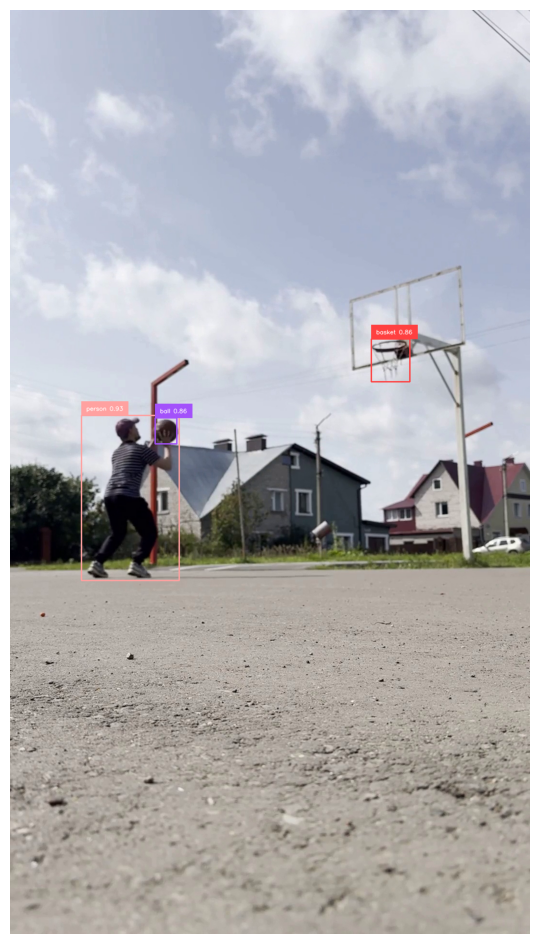

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/videos/freethrows_outdoors_ground_1_cut.mp4"
frames_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame = 0
for i in range(2220):
    frame = next(frames_generator) # get the 1st frame
detections = detect(frame)
print(detections)

# get person and ball bounding boxes coordinates of points of main diagonal
person_p1 = person_p2 = (0, 0)
ball_p1 = ball_p2 = (0, 0)
for obj in iter(detections):
    if obj[3] == 2:
        person_x1, person_y1, person_x2, person_y2 = obj[0]
        person_p1 = (person_x1, person_y1)
        person_p2 = (person_x2, person_y2)

    if obj[3] == 0:
        ball_x1, ball_y1, ball_x2, ball_y2 = obj[0]
        ball_p1 = (ball_x1, ball_y1)
        ball_p2 = (ball_x2, ball_y2)

ball_coord = (ball_p1, ball_p2)

# Protection against accidential ball detections
# detections, (ball_p1, ball_p2) = remove_ball_detections(detections, ball_coord, ((0, 0), (0, 0)))
print(detections)


# True, if person and ball bounding boxes intersect
intersect_person_ball = rectangles_intersect(person_p1, person_p2, ball_p1, ball_p2)
print(intersect_person_ball)


video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)

# labels for bounding boxes
labels = [
    f"{model.model.names[class_id]} {confidence:0.2f}"
    for confidence, class_id
    in zip(detections.confidence, detections.class_id)
]

# draw bounding boxes
annotated_frame = frame.copy()
annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)

sv.plot_image(annotated_frame)

Detections(xyxy=array([[     240.18,      751.59,      418.64,      1131.2],
       [     854.54,      600.37,      918.47,      700.27],
       [     755.56,      374.04,       804.3,      419.66],
       [     775.08,      1008.5,      818.65,        1035]], dtype=float32), mask=None, confidence=array([    0.94889,     0.85664,     0.80671,     0.74249], dtype=float32), class_id=array([2, 1, 0, 0]), tracker_id=None, data={'class_name': array(['person', 'basket', 'ball', 'ball'], dtype='<U6')})


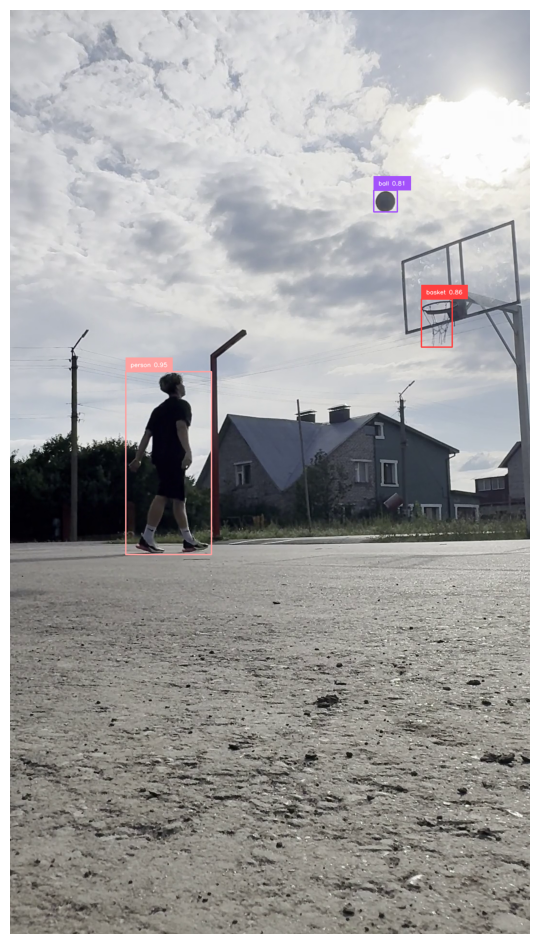

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/videos/gleb1.mp4"
frames_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame = 0
for i in range(310):
    frame = next(frames_generator) # get the 1st frame
detections = detect(frame)
print(detections)


# Get the indices of detections with class_id = 0
indices_class_0 = np.where(detections.class_id == 0)[0]

# Get the indices of detections with class_id != 0
indices_other_classes = np.where(detections.class_id != 0)[0]

# If there are any detections with class_id = 0
if len(indices_class_0) > 0:
    # Find the index of the detection with the highest confidence score among class_id = 0
    best_class_0_index = indices_class_0[np.argmax(detections.confidence[indices_class_0])]

    # Create a mask to include only the best detection with class_id = 0 and others
    mask = np.zeros(detections.class_id.shape, dtype=bool)
    mask[best_class_0_index] = True
    mask[indices_other_classes] = True

    # Apply the mask to filter the attributes
    filtered_detections = sv.Detections(
        xyxy=detections.xyxy[mask],
        confidence=detections.confidence[mask],
        class_id=detections.class_id[mask],
        mask=detections.mask,
        tracker_id=detections.tracker_id
    )
else:
    # If no detections with class_id = 0, just keep the detections with other class_ids
    filtered_detections = sv.Detections(
        xyxy=detections.xyxy[indices_other_classes],
        confidence=detections.confidence[indices_other_classes],
        class_id=detections.class_id[indices_other_classes],
        mask=detections.mask,
        tracker_id=detections.tracker_id
    )

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)

# labels for bounding boxes
labels = [
    f"{model.model.names[class_id]} {confidence:0.2f}"
    for confidence, class_id
    in zip(filtered_detections.confidence, filtered_detections.class_id)
]

# draw bounding boxes
annotated_frame = frame.copy()
annotated_frame = bounding_box_annotator.annotate(annotated_frame, filtered_detections)
annotated_frame = label_annotator.annotate(annotated_frame, filtered_detections, labels)

sv.plot_image(annotated_frame)

**Model inference with zones**

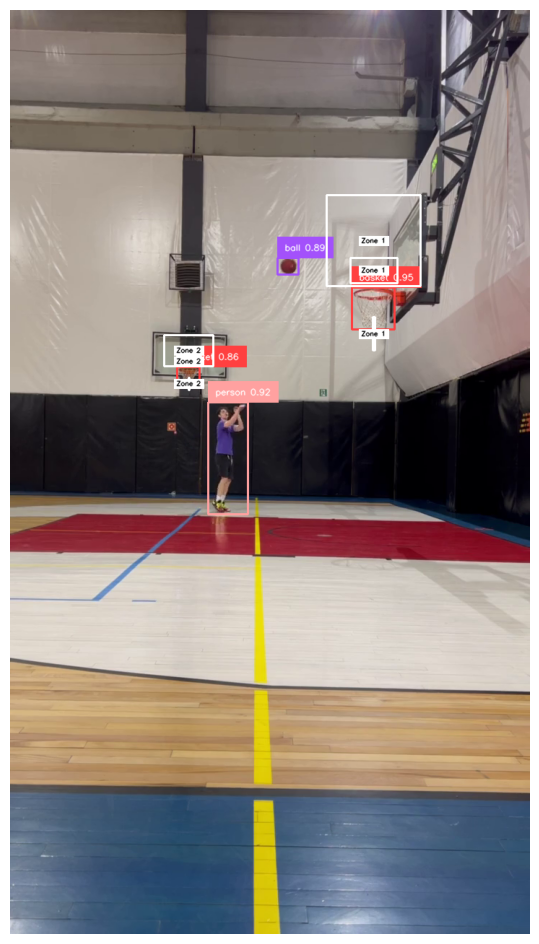

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/videos/yarik.mp4"
frames_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame = 0
for i in range(300):
    frame = next(frames_generator) # get the 1st frame
detections = detect(frame)

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)

zones_above = setup_zone_above(detections, video_info.resolution_wh)
zones_below = setup_zone_below(detections, video_info.resolution_wh)
zones_general = setup_zone_general(detections, video_info.resolution_wh, zones_above, zones_below)

# labels for bounding boxes
labels = [
    f"{model.model.names[class_id]} {confidence:0.2f}"
    for confidence, class_id
    in zip(detections.confidence, detections.class_id)
]

# draw bounding boxes
annotated_frame = frame.copy()
annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)

# draw zones
for zone in zones_above:
    annotated_frame = zone['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone['name']}"
    )

for zone in zones_below:
    annotated_frame = zone['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone['name']}"
    )

for zone in zones_general:
    annotated_frame = zone['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone['name']}"
    )

sv.plot_image(annotated_frame)

Detections(xyxy=array([[     731.16,       902.5,      880.93,      1161.1],
       [      750.1,       684.1,      833.09,      757.77],
       [     734.73,      972.53,      790.71,      1012.3]], dtype=float32), mask=None, confidence=array([    0.92871,     0.85412,     0.85224], dtype=float32), class_id=array([2, 1, 0]), tracker_id=None, data={'class_name': array(['person', 'basket', 'ball'], dtype='<U6')})


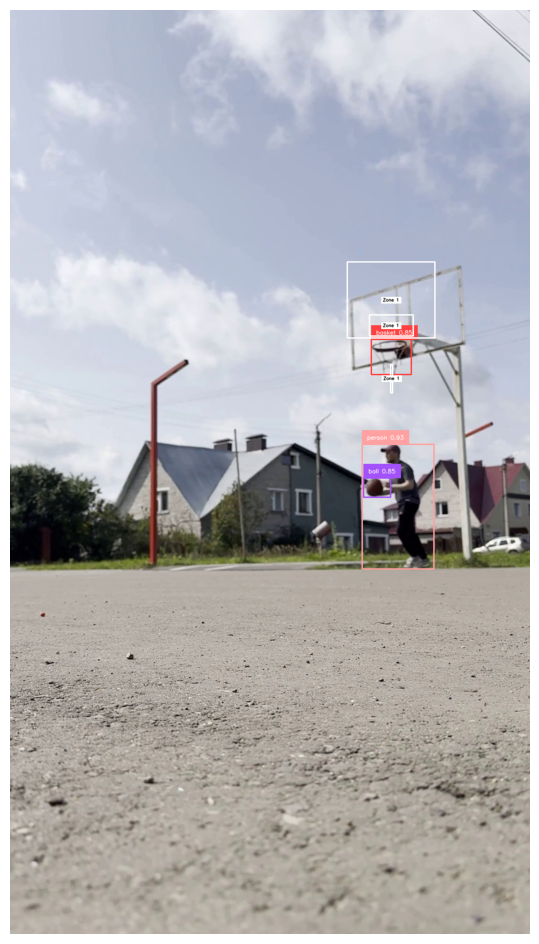

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/videos/freethrows_outdoors_ground_1.mp4"
frames_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame = 0
for i in range(3000):
    frame = next(frames_generator) # get the 1st frame
detections = detect(frame)
print(detections)
for obj in iter(detections):

    if obj[3] == 0:
        ball_x1, ball_y1, ball_x2, ball_y2 = obj[0]
        ball_p1 = (ball_x1, ball_y1)
        ball_p2 = (ball_x2, ball_y2)


video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)

zones_above = setup_zone_above(detections, video_info.resolution_wh)
zones_below = setup_zone_below(detections, video_info.resolution_wh)
zones_general = setup_zone_general(detections, video_info.resolution_wh, zones_above, zones_below)

# labels for bounding boxes
labels = [
    f"{model.model.names[class_id]} {confidence:0.2f}"
    for confidence, class_id
    in zip(detections.confidence, detections.class_id)
]

# draw bounding boxes
annotated_frame = frame.copy()
annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)

# draw zones
for zone in zones_above:
    annotated_frame = zone['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone['name']}"
    )

for zone in zones_below:
    annotated_frame = zone['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone['name']}"
    )

for zone in zones_general:
    annotated_frame = zone['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone['name']}"
    )

sv.plot_image(annotated_frame)

Detections(xyxy=array([[     176.31,      727.91,       361.2,        1184],
       [     749.53,      684.12,      832.55,      772.03],
       [     301.65,      733.41,      347.47,      786.47]], dtype=float32), mask=None, confidence=array([     0.9451,     0.89358,     0.53167], dtype=float32), class_id=array([2, 1, 0]), tracker_id=None, data={'class_name': array(['person', 'basket', 'ball'], dtype='<U6')})


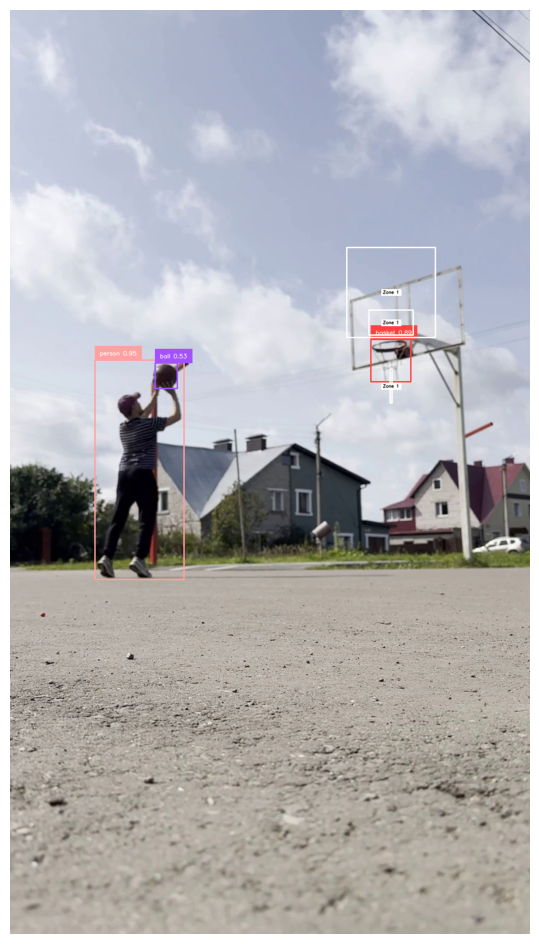

In [ ]:
# protection against accidential detections
SOURCE_VIDEO_PATH = f"{HOME}/videos/freethrows_outdoors_ground_1.mp4"
frames_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame = 0
for i in range(100):
    frame = next(frames_generator) # get the 1st frame
detections = detect(frame)
print(detections)
video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)

zones_above = setup_zone_above(detections, video_info.resolution_wh)
zones_below = setup_zone_below(detections, video_info.resolution_wh)
zones_general = setup_zone_general(detections, video_info.resolution_wh, zones_above, zones_below)

# labels for bounding boxes
labels = [
    f"{model.model.names[class_id]} {confidence:0.2f}"
    for confidence, class_id
    in zip(detections.confidence, detections.class_id)
]

# draw bounding boxes
annotated_frame = frame.copy()
annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)

# draw zones
for zone in zones_above:
    annotated_frame = zone['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone['name']}"
    )

for zone in zones_below:
    annotated_frame = zone['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone['name']}"
    )

for zone in zones_general:
    annotated_frame = zone['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone['name']}"
    )

sv.plot_image(annotated_frame)

Detections(xyxy=array([[     930.06,      836.98,      978.68,      878.12],
       [     854.38,      599.49,      915.46,      699.21],
       [        693,      795.67,      815.73,      1121.8]], dtype=float32), mask=None, confidence=array([    0.89444,     0.83604,     0.63258], dtype=float32), class_id=array([0, 1, 2]), tracker_id=None, data={'class_name': array(['ball', 'basket', 'person'], dtype='<U6')})
Detections(xyxy=array([[     930.06,      836.98,      978.68,      878.12],
       [     854.38,      599.49,      915.46,      699.21],
       [        693,      795.67,      815.73,      1121.8]], dtype=float32), mask=None, confidence=array([    0.89444,     0.83604,     0.63258], dtype=float32), class_id=array([0, 1, 2]), tracker_id=array([1, 2, 3]), data={})


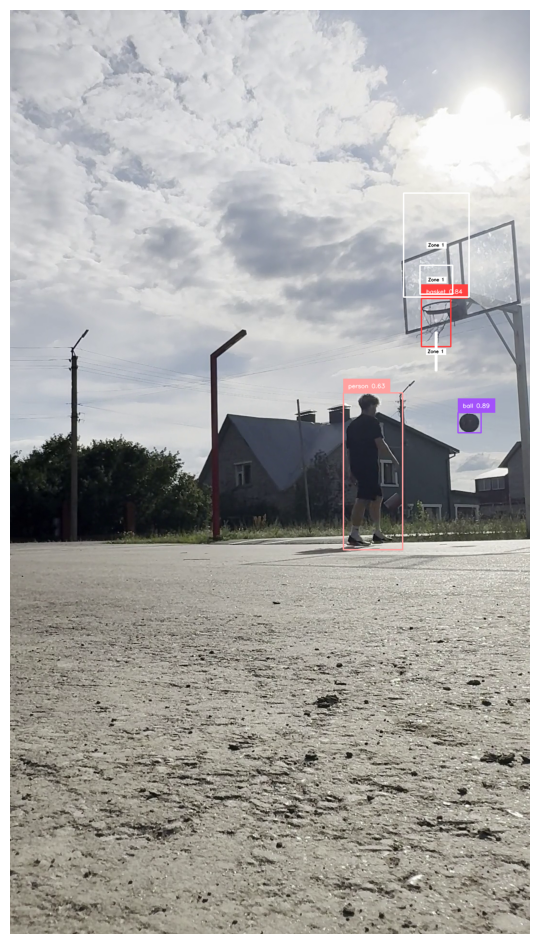

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/videos/gleb1.mp4"
frames_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame = 0
for i in range(900):
    frame = next(frames_generator) # get the 1st frame
detections_untracked = detect(frame)
print(detections_untracked)
detections = tracker.update_with_detections(detections_untracked)
print(detections)
detections.data = detections_untracked.data

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)

zones_above = setup_zone_above(detections, video_info.resolution_wh)
zones_below = setup_zone_below(detections, video_info.resolution_wh)
zones_general = setup_zone_general(detections, video_info.resolution_wh, zones_above, zones_below)

# labels for bounding boxes
labels = [
    f"{model.model.names[class_id]} {confidence:0.2f}"
    for confidence, class_id
    in zip(detections.confidence, detections.class_id)
]

# draw bounding boxes
annotated_frame = frame.copy()
annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)

# draw zones
for zone in zones_above:
    annotated_frame = zone['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone['name']}"
    )

for zone in zones_below:
    annotated_frame = zone['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone['name']}"
    )

for zone in zones_general:
    annotated_frame = zone['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone['name']}"
    )

sv.plot_image(annotated_frame)

Detections(xyxy=array([[     108.94,      378.64,      171.95,      516.45],
       [     415.08,      256.26,      460.56,      295.07],
       [     444.69,      236.74,      464.71,      259.01],
       [     112.47,      427.73,       138.4,       445.4]], dtype=float32), mask=None, confidence=array([    0.93084,     0.91065,     0.84563,      0.6779], dtype=float32), class_id=array([2, 1, 0, 0]), tracker_id=None, data={'class_name': array(['person', 'basket', 'ball', 'ball'], dtype='<U6')})


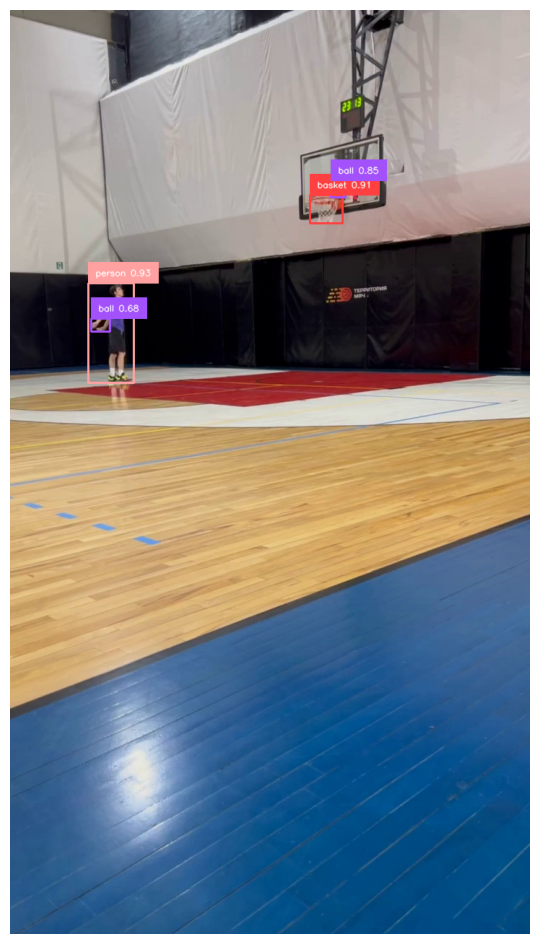

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/videos/yarik_tripid_throws_1.mp4"
frames_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame = 0
for i in range(40):
    frame = next(frames_generator) # get the 1st frame
detections = detect(frame)
print(detections)

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)


# labels for bounding boxes
labels = [
    f"{model.model.names[class_id]} {confidence:0.2f}"
    for confidence, class_id
    in zip(detections.confidence, detections.class_id)
]

# draw bounding boxes
annotated_frame = frame.copy()
annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)

sv.plot_image(annotated_frame)

In [ ]:
def choosing_largest_zone(zones):
    max_square = 0
    for zone in zones:
        zone_coord = zone.get('polygon')
        x1 = zone_coord[0][0]
        x2 = zone_coord[3][0]
        y1 = zone_coord[0][1]
        y2 = zone_coord[0][1]

        square = (x2 - x1) * (y2 - y1)

        if square > max_square:
            max_square = square

    for zone in zones:
        zone_coord = zone.get('polygon')
        x1 = zone_coord[0][0]
        x2 = zone_coord[3][0]
        y1 = zone_coord[0][1]
        y2 = zone_coord[0][1]

        if (x2 - x1) * (y2 - y1) == max_square:
            return zone


In [ ]:
def filter_balls(detections: sv.Detections):
    """
    Remove all instances of objects with class_id = 0 (ball instances), except for the one with the highest confidence score

    Return: filtered detections
    """

    # Get the indices of detections with class_id = 0
    indices_class_0 = np.where(detections.class_id == 0)[0]

    # Get the indices of detections with class_id != 0
    indices_other_classes = np.where(detections.class_id != 0)[0]

    # If there are any detections with class_id = 0
    if len(indices_class_0) > 0:
        # Find the index of the detection with the highest confidence score among class_id = 0
        best_class_0_index = indices_class_0[np.argmax(detections.confidence[indices_class_0])]

        # Create a mask to include only the best detection with class_id = 0 and others
        mask = np.zeros(detections.class_id.shape, dtype=bool)
        mask[best_class_0_index] = True
        mask[indices_other_classes] = True

        # Apply the mask to filter the attributes
        filtered_detections = sv.Detections(
            xyxy=detections.xyxy[mask],
            confidence=detections.confidence[mask],
            class_id=detections.class_id[mask],
            mask=detections.mask,
            tracker_id=detections.tracker_id
        )
    else:
        # If no detections with class_id = 0, just keep the detections with other class_ids
        filtered_detections = sv.Detections(
            xyxy=detections.xyxy[indices_other_classes],
            confidence=detections.confidence[indices_other_classes],
            class_id=detections.class_id[indices_other_classes],
            mask=detections.mask,
            tracker_id=detections.tracker_id
        )

    return filtered_detections


def remove_ball_detections(detections: sv.Detections, ball_coord, ball_prev_coord):
    """
    Protection against accidential detections:
    if the distance between two same points of the ball on the current and previous frames differs by 3 widths of the ball,
    we consider such detection of the ball to be random and false, so we remove this ball instance from detections

    Return: filtered detections if the condition is true, and unchanged detections if the condition is false
    """

    ball_p1 = ball_coord[0]
    ball_p2 = ball_coord[1]
    ball_width = abs(ball_p1[0] - ball_p2[0])

    ball_prev_p1 = ball_prev_coord[0]

    if abs(ball_p1[0] - ball_prev_p1[0]) > 3 * ball_width and ball_width != 0:
        # Filter out the detections with class_id != 0
        mask = detections.class_id != 0

        # Apply the mask to filter the attributes
        filtered_detections = sv.Detections(
            xyxy=detections.xyxy[mask],
            confidence=detections.confidence[mask],
            class_id=detections.class_id[mask],
            mask=detections.mask,
            tracker_id=detections.tracker_id
        )
        ball_coord = ((0, 0), (0, 0))
        print("accidential detection")
        return filtered_detections, ball_coord

    return detections, ball_coord

In [ ]:
def callback(frame: np.ndarray, frame_wh, frame_num: int, zone_above, zone_below, zone_general, zones_identified, zone_above_triggered, zone_general_triggered, score, throws, ball_prev_coord) -> np.ndarray:

    detections = detect(frame)
    detections = filter_balls(detections)

    # get ball bounding boxes coordinates of points of main diagonal
    ball_p1 = ball_p2 = (0, 0)
    for obj in iter(detections):
        if obj[3] == 0:
            ball_x1, ball_y1, ball_x2, ball_y2 = obj[0]
            ball_p1 = (ball_x1, ball_y1)
            ball_p2 = (ball_x2, ball_y2)
    ball_coord = (ball_p1, ball_p2)

    # Protection against accidential ball detections
    detections, (ball_p1, ball_p2) = remove_ball_detections(detections, ball_coord, ball_prev_coord)

    intersect_person_ball = False
    for obj in iter(detections):
        if obj[3] == 2:
            person_x1, person_y1, person_x2, person_y2 = obj[0]
            person_p1 = (person_x1, person_y1)
            person_p2 = (person_x2, person_y2)

            # True, if person and ball bounding boxes intersect
            intersect_person_ball = rectangles_intersect(person_p1, person_p2, ball_p1, ball_p2)

            if intersect_person_ball:
                break

    if not zones_identified:
        zones_above = setup_zone_above(detections, frame_wh)
        zones_below = setup_zone_below(detections, frame_wh)
        zones_general = setup_zone_general(detections, frame_wh, zones_above, zones_below)

        # choose only one zone above, below and general by greatest size
        zone_above = choosing_largest_zone(zones_above)
        zone_below = choosing_largest_zone(zones_below)
        zone_general = choosing_largest_zone(zones_general)

        if (zone_above, zone_below, zone_general) != (None, None, None):
            zones_identified = True


    # bounding boxes labels
    labels = [
        f"{model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id
        in zip(detections.confidence, detections.class_id)
    ]

    # draw bounding boxes with labels
    annotated_frame = frame.copy()
    annotated_frame = bounding_box_annotator.annotate(
        scene=annotated_frame,
        detections=detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        labels=labels)


    # Draw text for person and ball intersection
    text_anchor = sv.Point(x=500, y=200)
    if intersect_person_ball:
        annotated_frame = draw_text(scene=annotated_frame, text=f"Person and ball intersect: {intersect_person_ball}", text_anchor=text_anchor, text_scale=1, text_thickness=2, text_color=Color.GREEN)
    else:
        annotated_frame = draw_text(scene=annotated_frame, text=f"Person and ball intersect: {intersect_person_ball}", text_anchor=text_anchor, text_scale=1, text_thickness=2, text_color=Color.RED)

    if zones_identified:
        zone_presence_above = zone_above['PolygonZone'].trigger(detections, 0)
        zone_presence_below = zone_below['PolygonZone'].trigger(detections, 0)
        zone_presence_general = zone_general['PolygonZone'].trigger(detections, 0)

        # write text for above zone
        text_anchor = sv.Point(x=500, y=50)
        if zone_presence_above and not intersect_person_ball:
            annotated_frame = draw_text(scene=annotated_frame, text=f"Ball in above zone: {zone_presence_above}", text_anchor=text_anchor, text_scale=1, text_thickness=2, text_color=Color.GREEN)
            zone_above['count'] += 1
            zone_above_triggered = True
        else:
            annotated_frame = draw_text(scene=annotated_frame, text=f"Ball in above zone: {zone_presence_above}", text_anchor=text_anchor, text_scale=1, text_thickness=2, text_color=Color.RED)

        # write text for below zone
        text_anchor = sv.Point(x=500, y=100)
        if zone_presence_below and not intersect_person_ball:
            annotated_frame = draw_text(scene=annotated_frame, text=f"Ball in below zone: {zone_presence_below}", text_anchor=text_anchor, text_scale=1, text_thickness=2, text_color=Color.GREEN)
            zone_below['count'] += 1
        else:
            annotated_frame = draw_text(scene=annotated_frame, text=f"Ball in below zone: {zone_presence_below}", text_anchor=text_anchor, text_scale=1, text_thickness=2, text_color=Color.RED)

        # write text for general zone
        text_anchor = sv.Point(x=500, y=150)
        if zone_presence_general and not intersect_person_ball:
            annotated_frame = draw_text(scene=annotated_frame, text=f"Ball in general zone: {zone_presence_general}", text_anchor=text_anchor, text_scale=1, text_thickness=2, text_color=Color.GREEN)
            zone_general['count'] += 1
            zone_general_triggered = True
        else:
            annotated_frame = draw_text(scene=annotated_frame, text=f"Ball in general zone: {zone_presence_general}", text_anchor=text_anchor, text_scale=1, text_thickness=2, text_color=Color.RED)



        # if the above zone is triggered by ball, we wait for the zone below to also be triggered by ball.
        # If the outcome when player touches the ball ccures earlier, than the zone below is triggered by ball, then we reset the zone_above_triggered to False.
        if zone_above_triggered and zone_presence_below and not intersect_person_ball:
            score += 1
            zone_above_triggered = False
        elif zone_above_triggered and intersect_person_ball:
            zone_above_triggered = False

        # if the general zone is triggered by ball, we wait till the player touches the ball. Then we conclude that the throw was made
        if zone_general_triggered and intersect_person_ball:
            throws += 1
            zone_general_triggered = False



        annotated_frame = zone_above['PolygonZoneAnnotator'].annotate(
            scene=annotated_frame,
            label=f"{zone_above['name']}: {zone_above['count']}"
        )

        annotated_frame = zone_below['PolygonZoneAnnotator'].annotate(
            scene=annotated_frame,
            label=f"{zone_below['name']}: {zone_below['count']}"
        )

        annotated_frame = zone_general['PolygonZoneAnnotator'].annotate(
            scene=annotated_frame,
            label=f"{zone_general['name']}: {zone_general['count']}"
        )

    # draw text for score
    text_anchor = sv.Point(x=130, y=50)
    annotated_frame = draw_text(scene=annotated_frame, text=f"Score: {score}", text_anchor=text_anchor, text_scale=1.5, text_thickness=2)

    # draw text for throws
    text_anchor = sv.Point(x=130, y=100)
    annotated_frame = draw_text(scene=annotated_frame, text=f"Throws: {throws}", text_anchor=text_anchor, text_scale=1.5, text_thickness=2)

    ball_prev_coord = ball_coord

    return annotated_frame, zone_above, zone_below, zone_general, zones_identified, zone_above_triggered, zone_general_triggered, score, throws, ball_prev_coord

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/videos/3pthrows_outdoors_ground_2.mp4"
TARGET_VIDEO_PATH = f"{HOME}/videos/3pthrows_outdoors_ground_2_bytetrack.mp4"

# SOURCE_VIDEO_PATH = f"{HOME}/videos/gleb1_cut.mp4"
# TARGET_VIDEO_PATH = f"{HOME}/videos/gleb1_cut_traced.mp4"

frames_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)

zone_above = {}
zone_below = {}
zone_general = {}
zones_identified = False
zone_above_triggered = False
zone_general_triggered = False
score = 0
throws = 0
ball_prev_coord = ((0, 0), (0, 0))

with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink:
    for i, frame in enumerate(frames_generator):

        # Infer
        annotated_frame, zone_above, zone_below, zone_general, zones_identified, zone_above_triggered, zone_general_triggered, score, throws, ball_prev_coord = \
        callback(frame, video_info.resolution_wh, i, zone_above, zone_below, zone_general, zones_identified, zone_above_triggered, zone_general_triggered, score, throws, ball_prev_coord)

        print(f"Processing frame {i}, Score {score}, Throws {throws}")
        sink.write_frame(frame=annotated_frame)